In [1]:
import torch, tqdm 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

In [4]:
# Data
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!


/usr/local/miniconda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(in_features=784, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)


net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [6]:
# Parameters
epochs = 100
lr = 0.002
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

In [10]:
# Train
epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
#     pbar = tqdm.tqdm(total=len(trainLoader))
    for times, data in enumerate(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Foward + backward + optimize
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        running_acc += (labels==predicted).sum().item()
#         pbar.update(1) 
#         if times % 100 == 99 or times+1 == len(trainLoader):
#             print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/2000))
    _epoch_loss = running_loss/len(trainLoader)
    _epoch_acc = running_acc/len(trainLoader)
    epoch_loss.append(_epoch_loss)
    epoch_acc.append(_epoch_acc)
    print(epoch+1, _epoch_loss, _epoch_acc)
print('Training Finished.')


 57%|█████▋    | 536/938 [00:14<00:02, 141.93it/s]

1 0.15308082775909826 61.062899786780385
2 0.1360520682990678 61.37953091684435
3 0.12375896788045351 61.63006396588486
4 0.11018134862966915 61.90298507462686
5 0.1019975898989927 62.02238805970149
6 0.09201517378859746 62.22601279317697
7 0.08486302653804167 62.38059701492537
8 0.07889230833001641 62.4680170575693
9 0.0728829675324277 62.60341151385928
10 0.06874740670925614 62.66204690831557
11 0.06372060979615206 62.791044776119406
12 0.059279840436579384 62.847547974413644
13 0.05615711601044951 62.91684434968017
14 0.05239652858789899 62.97014925373134
15 0.04928961913682211 63.04477611940298
16 0.04636775118498398 63.11727078891258
17 0.04403341082043882 63.142857142857146
18 0.04061206498308413 63.211087420042645
19 0.03893992460634647 63.26226012793177
20 0.03751060452241736 63.276119402985074
21 0.035158718560339766 63.29957356076759
22 0.031846299796908305 63.37953091684435
23 0.03047127995070622 63.40298507462686
24 0.029155045847045077 63.42963752665245
25 0.02785709486977

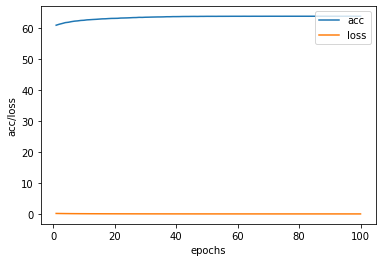

In [11]:
x = np.linspace(1, epochs, num = epochs)
plt.plot(x, epoch_acc, label='acc')
plt.plot(x, epoch_loss, label='loss')
plt.xlabel('epochs')
plt.ylabel('acc/loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
#             print(class_correct)
#             print(class_total)

for i in range(10):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 97 %
Accuracy of 0: 0.973684
Accuracy of 1: 0.983784
Accuracy of 2: 0.965116
Accuracy of 3: 0.961538
Accuracy of 4: 0.983051
Accuracy of 5: 0.976190
Accuracy of 6: 0.976562
Accuracy of 7: 0.975610
Accuracy of 8: 0.965035
Accuracy of 9: 0.982036
